Further process taxi data, add taxi density columns based on taxi counts.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

In [2]:
shapefile_path = 'nyc_taxi_zones/geo_export_256ac8cd-854b-4df2-8b77-35675aff5e3d.shp'
taxi_zones = gpd.read_file(shapefile_path)

taxi_zones = taxi_zones.to_crs(epsg=32618)

taxi_zones['area_km2'] = taxi_zones['geometry'].area / 10**6

taxi_data = pd.read_csv('taxi_processed_hourly.csv')

taxi_data = taxi_data.merge(taxi_zones[['location_i', 'area_km2']], left_on='loc', right_on='location_i', how='left')

taxi_data['pu_density'] = taxi_data['pu_count'] / taxi_data['area_km2']
taxi_data['do_density'] = taxi_data['do_count'] / taxi_data['area_km2']
taxi_data['total_density'] = taxi_data['total_count'] / taxi_data['area_km2']

output_file = 'taxi_density_processed_hourly.csv'
taxi_data.to_csv(output_file, index=False)

Draw traffic density for each zone, averagely.

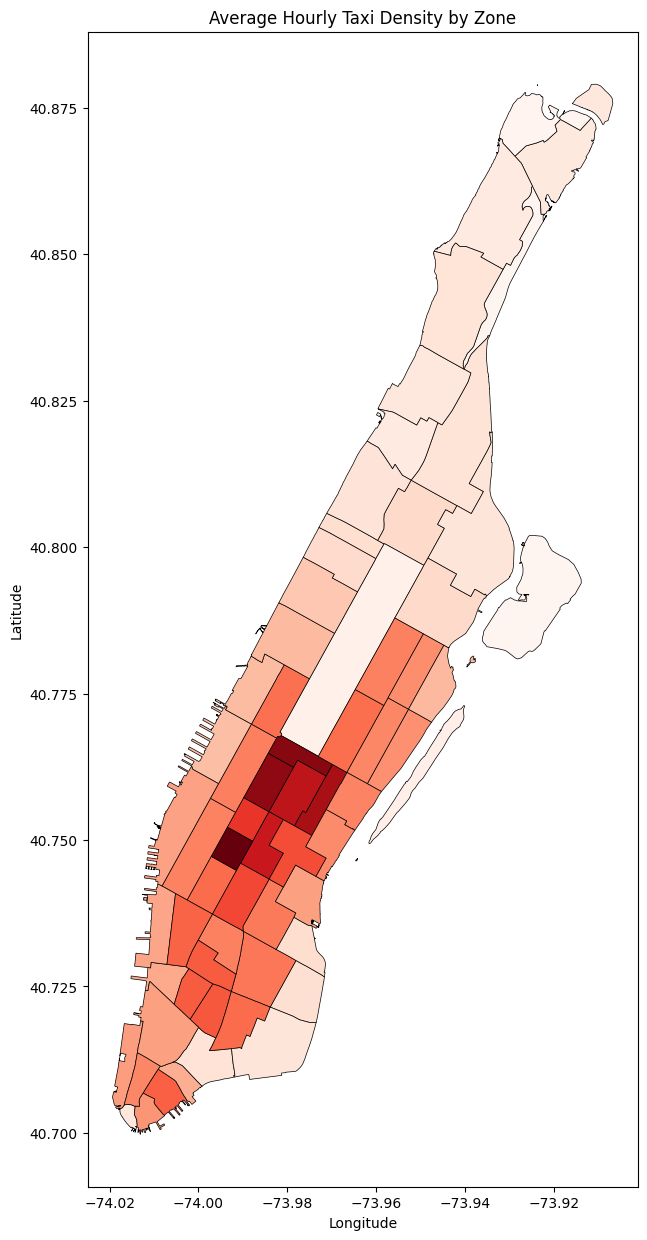

In [3]:
average_density = taxi_data.groupby('loc').mean(numeric_only=True)[['pu_density', 'do_density', 'total_density']].reset_index()

taxi_zones = taxi_zones.merge(average_density, left_on='location_i', right_on='loc', how='left')

taxi_zones = taxi_zones.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(15, 15))

taxi_zones.plot(ax=ax, column='total_density', cmap='Reds', edgecolor='black', linewidth=0.5, legend=False)

ax.set_title('Average Hourly Taxi Density by Zone')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Add traffic density column to final grid data.

In [4]:
import pandas as pd
import numpy as np

grid_info = pd.read_csv('grid_info_full_ver.csv')
final_grid_data = pd.read_csv('final_grid_data.csv')

relevant_grids = final_grid_data['grid_code'].unique()
grid_info = grid_info[grid_info['grid_code'].isin(relevant_grids)]

grid_to_zones = {}
for idx, row in grid_info.iterrows():
    grid_code = row['grid_code']
    intersect_dict = eval(row['taxi_zones'])
    grid_to_zones[grid_code] = intersect_dict

all_zones = set()
for zones in grid_to_zones.values():
    all_zones.update(zones.keys())
all_zones = sorted(all_zones)

zone_to_index = {zone: i for i, zone in enumerate(all_zones)}
grid_to_index = {grid: i for i, grid in enumerate(relevant_grids)}

conversion_matrix = np.zeros((len(relevant_grids), len(all_zones)))

for grid_code, zones in grid_to_zones.items():
    for zone, area in zones.items():
        grid_idx = grid_to_index[grid_code]
        zone_idx = zone_to_index[zone]
        conversion_matrix[grid_idx, zone_idx] = area

np.save('conversion_matrix.npy', conversion_matrix)
np.save('zone_to_index.npy', zone_to_index)
np.save('grid_to_index.npy', grid_to_index)

In [5]:
conversion_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
grid_to_index

{'0@7': 0,
 '0@8': 1,
 '0@9': 2,
 '1@9': 3,
 '3@6': 4,
 '3@7': 5,
 '4@6': 6,
 '4@7': 7,
 '4@8': 8,
 '4@10': 9,
 '4@11': 10,
 '5@6': 11,
 '5@7': 12,
 '5@8': 13,
 '5@9': 14,
 '5@10': 15,
 '5@11': 16,
 '5@12': 17,
 '5@13': 18,
 '5@14': 19,
 '5@15': 20,
 '5@16': 21,
 '6@6': 22,
 '6@7': 23,
 '6@9': 24,
 '6@10': 25,
 '6@11': 26,
 '6@12': 27,
 '6@13': 28,
 '6@14': 29,
 '6@15': 30,
 '6@16': 31,
 '6@17': 32,
 '6@18': 33,
 '6@19': 34,
 '6@20': 35,
 '7@6': 36,
 '7@7': 37,
 '7@8': 38,
 '7@9': 39,
 '7@10': 40,
 '7@11': 41,
 '7@12': 42,
 '7@13': 43,
 '7@14': 44,
 '7@15': 45,
 '7@16': 46,
 '7@17': 47,
 '7@18': 48,
 '7@19': 49,
 '7@20': 50,
 '7@21': 51,
 '7@22': 52,
 '8@7': 53,
 '8@8': 54,
 '8@9': 55,
 '8@10': 56,
 '8@11': 57,
 '8@12': 58,
 '8@13': 59,
 '8@14': 60,
 '8@15': 61,
 '8@16': 62,
 '8@17': 63,
 '8@18': 64,
 '8@19': 65,
 '8@20': 66,
 '8@21': 67,
 '8@22': 68,
 '8@23': 69,
 '9@8': 70,
 '9@9': 71,
 '9@10': 72,
 '9@11': 73,
 '9@12': 74,
 '9@13': 75,
 '9@14': 76,
 '9@15': 77,
 '9@16': 78,
 '9@17':

In [7]:
conversion_matrix = np.load('conversion_matrix.npy')
zone_to_index = np.load('zone_to_index.npy', allow_pickle=True).item()
grid_to_index = np.load('grid_to_index.npy', allow_pickle=True).item()

time_density_data = taxi_data[['hourly_time', 'loc', 'pu_density', 'do_density', 'total_density']]
time_density_data.loc[:, 'hourly_time'] = pd.to_datetime(time_density_data['hourly_time'])

final_density_data = []

count = 0

for timestamp in final_grid_data['time_stamp'].unique():

    time_specific_density = time_density_data[time_density_data['hourly_time'] == pd.to_datetime(timestamp, unit='s')]
    
    if time_specific_density.empty:
        continue

    zone_density_vector = np.zeros(len(zone_to_index))
    for idx, row in time_specific_density.iterrows():
        zone_id = row['loc']
        if zone_id in zone_to_index:
            zone_idx = zone_to_index[zone_id]
            zone_density_vector[zone_idx] = row['total_density']

    grid_density_vector = conversion_matrix.dot(zone_density_vector)

    for grid_code, grid_idx in grid_to_index.items():
        grid_density = grid_density_vector[grid_idx]
        final_density_data.append([grid_code, timestamp, grid_density])
    
    count += 1
    if count % 100 == 0:
        print(f'{count}, time: {pd.to_datetime(timestamp, unit="s")}')

final_density_df = pd.DataFrame(final_density_data, columns=['grid_code', 'time_stamp', 'taxi_density'])
final_density_df = final_density_df.merge(final_grid_data, on=['grid_code', 'time_stamp'], how='left')

final_density_df.to_csv('final_grid_dataset_1.csv', index=False)

100, time: 2023-04-05 04:00:00
200, time: 2023-04-09 08:00:00
300, time: 2023-04-13 12:00:00
400, time: 2023-04-17 16:00:00
500, time: 2023-04-21 20:00:00
600, time: 2023-04-26 00:00:00
700, time: 2023-05-01 04:00:00
800, time: 2023-05-05 08:00:00
900, time: 2023-05-09 12:00:00
1000, time: 2023-05-13 16:00:00
1100, time: 2023-05-17 20:00:00
1200, time: 2023-05-22 00:00:00
1300, time: 2023-05-26 04:00:00
1400, time: 2023-05-30 08:00:00
1500, time: 2023-06-04 12:00:00
1600, time: 2023-06-08 16:00:00
1700, time: 2023-06-12 20:00:00
1800, time: 2023-06-17 00:00:00
1900, time: 2023-06-21 04:00:00
2000, time: 2023-06-25 08:00:00
2100, time: 2023-06-29 12:00:00
2200, time: 2023-07-04 16:00:00
2300, time: 2023-07-08 20:00:00
2400, time: 2023-07-13 00:00:00
2500, time: 2023-07-17 04:00:00
2600, time: 2023-07-21 08:00:00
2700, time: 2023-07-25 12:00:00
2800, time: 2023-07-29 16:00:00
2900, time: 2023-08-03 20:00:00
3000, time: 2023-08-08 00:00:00
3100, time: 2023-08-12 04:00:00
3200, time: 2023-

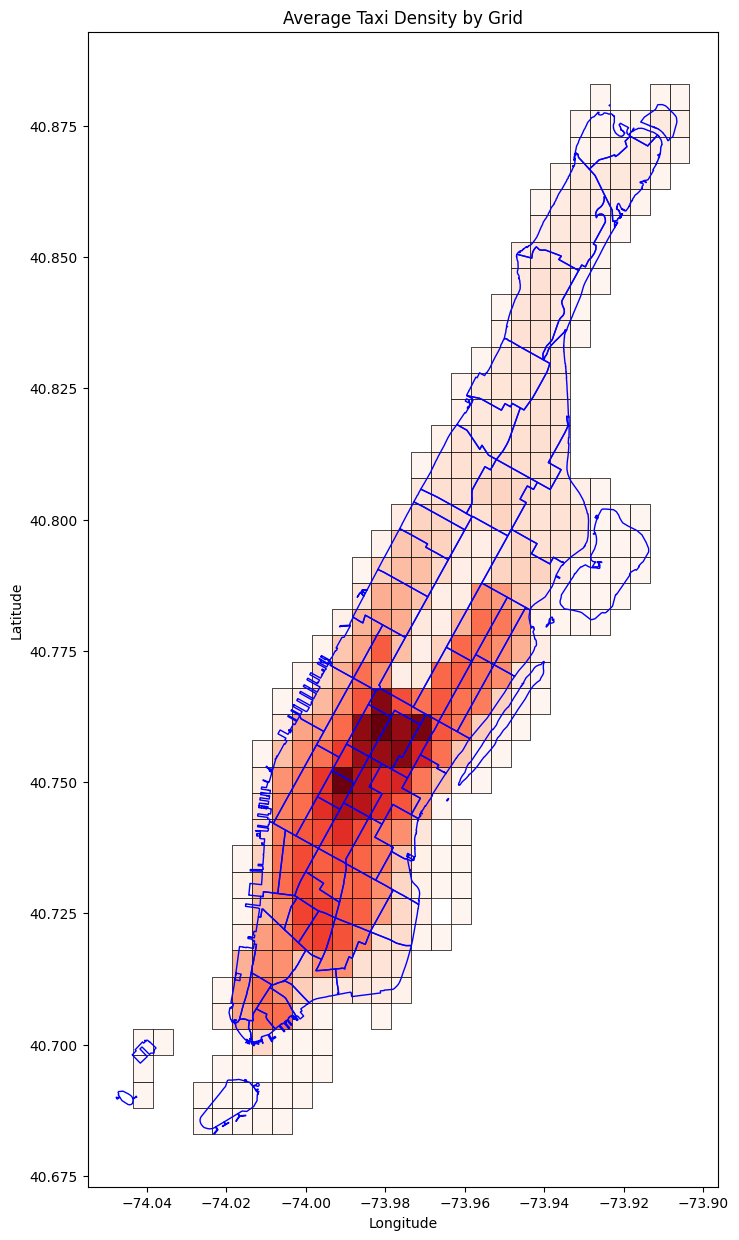

In [8]:
final_density_df = pd.read_csv('final_grid_dataset_1.csv')

average_density = final_density_df.groupby('grid_code')['taxi_density'].mean().reset_index()

average_density = average_density.merge(grid_info[['grid_code', 'min_lon', 'max_lon', 'min_lat', 'max_lat']], on='grid_code', how='left')

def create_polygon(row):
    return Polygon([(row['min_lon'], row['min_lat']), 
                    (row['min_lon'], row['max_lat']),
                    (row['max_lon'], row['max_lat']),
                    (row['max_lon'], row['min_lat'])])

average_density['geometry'] = average_density.apply(create_polygon, axis=1)
gdf = gpd.GeoDataFrame(average_density, geometry='geometry')

gdf = gdf.set_crs(epsg=4326)

manhattan_zones = taxi_zones[taxi_zones['borough'] == 'Manhattan']

manhattan_zones = manhattan_zones.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(ax=ax, column='taxi_density', cmap='Reds', edgecolor='black', linewidth=0.5)

manhattan_zones.boundary.plot(ax=ax, color='blue', linewidth=1)

ax.set_title('Average Taxi Density by Grid')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()